# Business Understanding

SyriaTel, a telecommunications provider, faces revenue loss due to customer churn. The goal is to develop a predictive model that identifies customers likely to churn, allowing proactive retention strategies. By analyzing behavioral patterns, we aim to provide actionable insights to reduce churn and improve customer satisfaction.



# Data Understanding

The dataset consists of **3,333** customer records with **21** attributes, including:
- **Customer Plans:** International and Voicemail plans.
- **Usage Metrics:** Call durations (day, evening, night, international), number of calls, and charges.
- **Customer Support Interaction:** Number of customer service calls.
- **Target Variable:** `churn` (binary: True = churned, False = retained).

In [1]:
# import relevant libraries
import csv 
import pandas as pd 
import seaborn as sns
import numpy as np


# Data visualization
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

# Modeling
import sklearn
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV 
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,roc_curve,roc_auc_score,classification_report 

# performance metrics
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Algorithms for supervised learning methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Filtering future warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the dataset
file_path = "bigml.csv"
with open(file_path, 'r') as file:
    telecoms_df = pd.read_csv(file)

# Print a message to confirm data loading
print("Data loaded successfully!")


Data loaded successfully!


In [3]:
# Display basic info about the dataset
telecoms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

### **2.2. Exploratory Data Analysis (EDA)**

### Customer Service Experience

### Does a higher number of customer service calls correlate with higher churn rates?

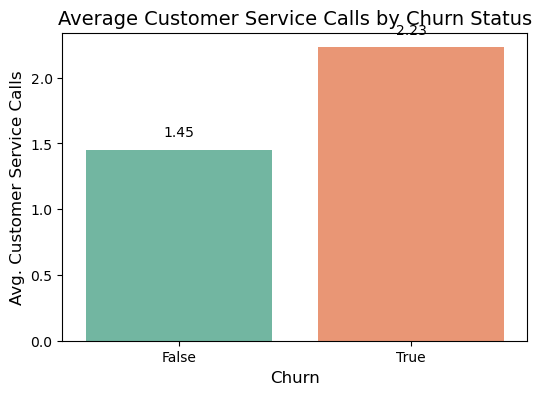

In [4]:
# Group by churn and calculate average customer service calls
service_calls_churn = telecoms_df.groupby("churn")["customer service calls"].mean()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=service_calls_churn.index, y=service_calls_churn.values, palette='Set2')

# Add labels
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Avg. Customer Service Calls", fontsize=12)
plt.title("Average Customer Service Calls by Churn Status", fontsize=14)

# Show values on bars
for i, value in enumerate(service_calls_churn.values):
    plt.text(i, value + 0.1, f"{value:.2f}", ha="center", fontsize=10)

plt.show()

   - Customers with **more service calls** are more likely to churn. 
   
   - High service calls indicate unresolved issues or dissatisfaction.

### Do customers with frequent customer service calls and high charges churn more?
>Exploring the Link Between Customer Complaints, Billing, and Churn

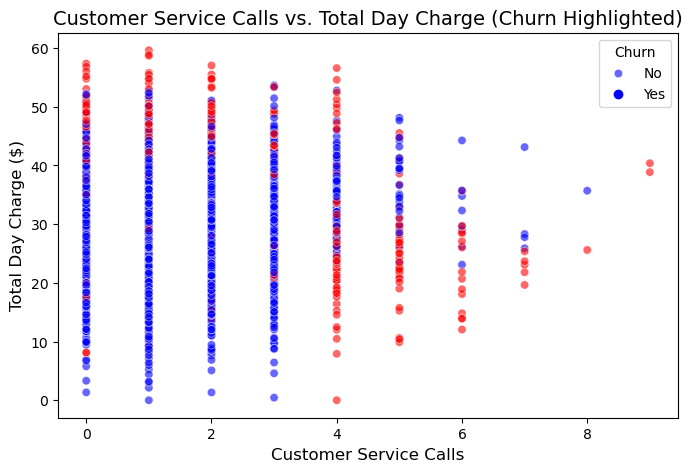

In [5]:
# Scatter plot: Customer Service Calls vs. Total Charges, colored by Churn
plt.figure(figsize=(8, 5))
sns.scatterplot(x=telecoms_df["customer service calls"], 
                y=telecoms_df["total day charge"], 
                hue=telecoms_df["churn"], 
                palette={0: "blue", 1: "red"}, alpha=0.6)

# Add labels
plt.xlabel("Customer Service Calls", fontsize=12)
plt.ylabel("Total Day Charge ($)", fontsize=12)
plt.title("Customer Service Calls vs. Total Day Charge (Churn Highlighted)", fontsize=14)
plt.legend(title="Churn", labels=["No", "Yes"])

plt.show()


- The number of calls alone does not strongly impact churn.
- Total minutes and charges are stronger indicators.

### Usage & Billing

### Do customers with higher total charges (day/evening/night/international) churn more?
>Investigating the Relationship Between Total Charges and Churn

<Figure size 800x500 with 0 Axes>

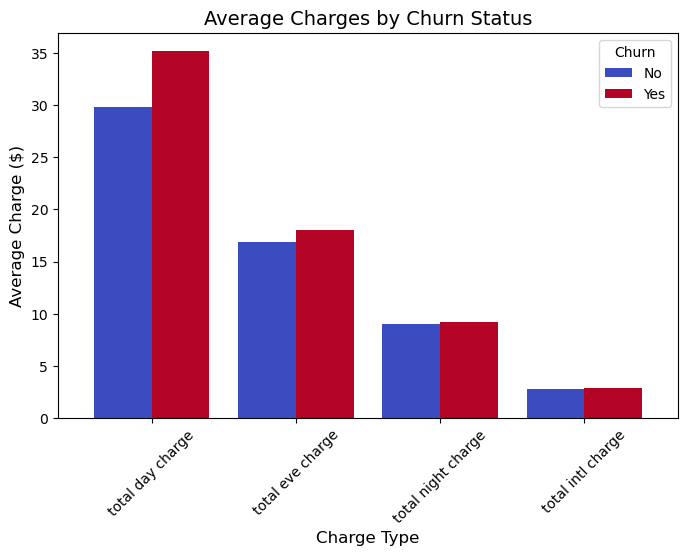

In [6]:
# Select charge-related columns
charge_columns = ["total day charge", "total eve charge", "total night charge", "total intl charge", "churn"]

# Calculate average charges for churned vs. non-churned customers
charges_churn = telecoms_df.groupby("churn")[charge_columns[:-1]].mean().T

# Plot
plt.figure(figsize=(8, 5))
charges_churn.plot(kind="bar", figsize=(8, 5), colormap="coolwarm", width=0.8)

# Add labels
plt.xlabel("Charge Type", fontsize=12)
plt.ylabel("Average Charge ($)", fontsize=12)
plt.title("Average Charges by Churn Status", fontsize=14)
plt.xticks(rotation=45)

plt.legend(title="Churn", labels=["No", "Yes"])
plt.show()


   - Churned customers have **higher total charges** across all time periods.  
   - High costs could be a key reason for customer churn.

### Does total usage (minutes/calls) affect churn?

<Figure size 1000x500 with 0 Axes>

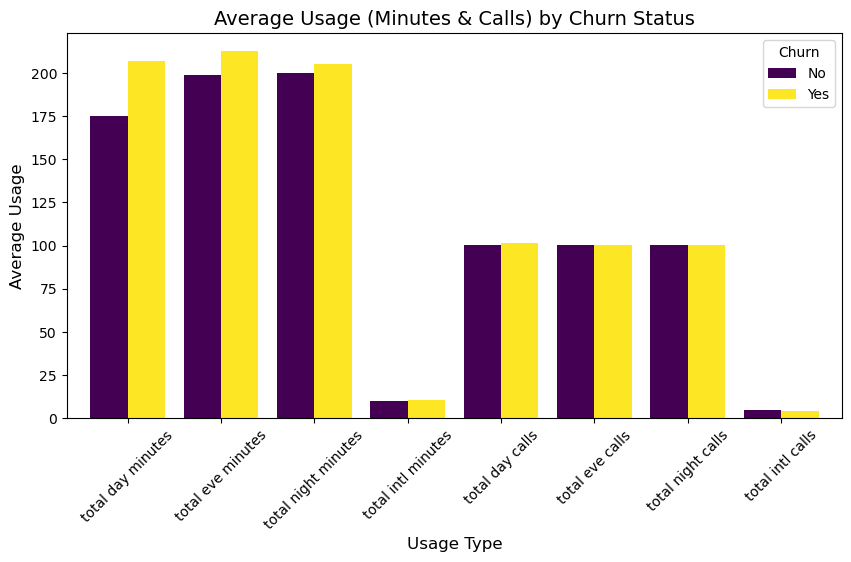

In [7]:
# Select usage-related columns
usage_columns = ["total day minutes", "total eve minutes", "total night minutes", "total intl minutes",
                 "total day calls", "total eve calls", "total night calls", "total intl calls", "churn"]

# Calculate average usage for churned vs. non-churned customers
usage_churn = telecoms_df.groupby("churn")[usage_columns[:-1]].mean().T

# Plot
plt.figure(figsize=(10, 5))
usage_churn.plot(kind="bar", figsize=(10, 5), colormap="viridis", width=0.8)

# Add labels
plt.xlabel("Usage Type", fontsize=12)
plt.ylabel("Average Usage", fontsize=12)
plt.title("Average Usage (Minutes & Calls) by Churn Status", fontsize=14)
plt.xticks(rotation=45)

plt.legend(title="Churn", labels=["No", "Yes"])
plt.show()


   - Customers who use **more minutes churn more**.  
   - Heavy users might be dissatisfied with **pricing or service quality**. 

### Plan & Features

### Does having an international plan increase churn rates?

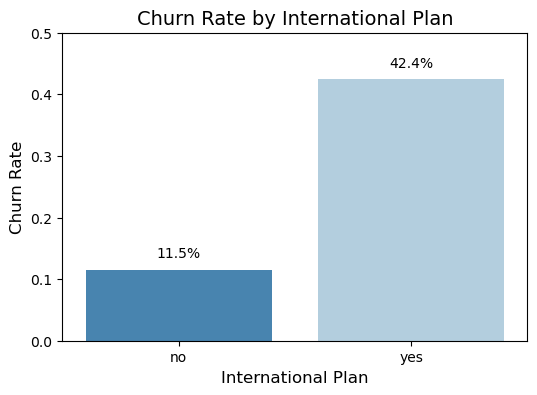

In [8]:
# Calculate churn rate for customers with and without an international plan
intl_plan_churn = telecoms_df.groupby("international plan")["churn"].mean()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=intl_plan_churn.index, y=intl_plan_churn.values, palette="Blues_r")

# Add labels
plt.xlabel("International Plan", fontsize=12)
plt.ylabel("Churn Rate", fontsize=12)
plt.title("Churn Rate by International Plan", fontsize=14)
plt.ylim(0, 0.5)

# Show values on bars
for i, value in enumerate(intl_plan_churn.values):
    plt.text(i, value + 0.02, f"{value:.1%}", ha="center", fontsize=10)

plt.show()


   - Customers with an **international plan churn more** than those without one.  
   - This suggests possible **pricing or service quality concerns**.

### Does having a voicemail plan impact churn?
>Exploring the relationship between voicemail subscription and customer retention

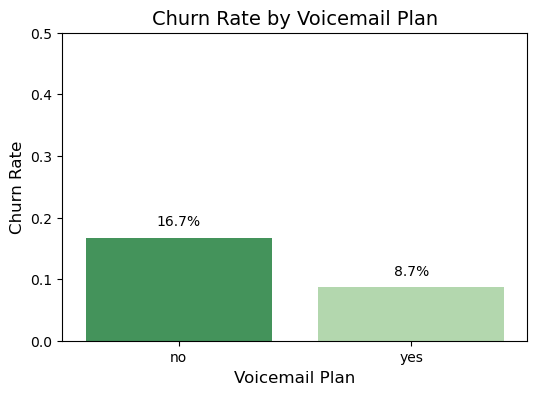

In [9]:
# Calculate churn rate for customers with and without a voicemail plan
voicemail_plan_churn = telecoms_df.groupby("voice mail plan")["churn"].mean()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=voicemail_plan_churn.index, y=voicemail_plan_churn.values, palette="Greens_r")

# Add labels
plt.xlabel("Voicemail Plan", fontsize=12)
plt.ylabel("Churn Rate", fontsize=12)
plt.title("Churn Rate by Voicemail Plan", fontsize=14)
plt.ylim(0, 0.5)

# Show values on bars
for i, value in enumerate(voicemail_plan_churn.values):
    plt.text(i, value + 0.02, f"{value:.1%}", ha="center", fontsize=10)

plt.show()


   - Customers **without a voicemail plan churn more**.  
   - Voicemail might be a valuable feature that retains customers.

### State & Geographic Factors


### Are churn rates higher in certain states?

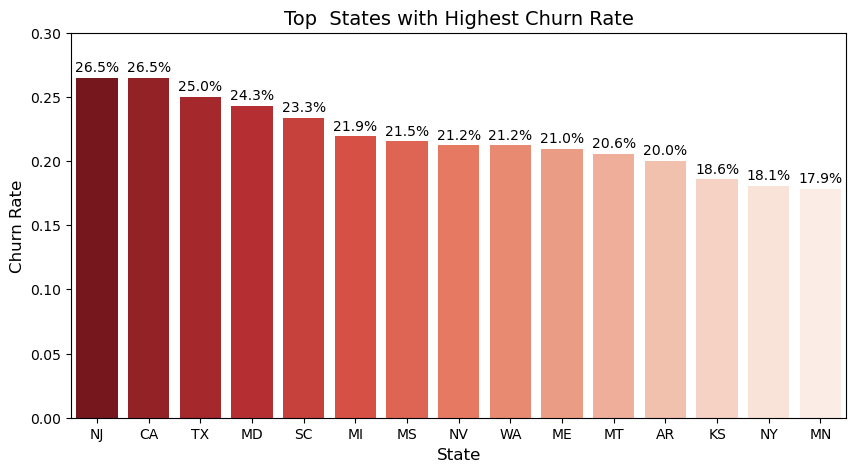

In [10]:
# Calculate churn rate per state
churn_by_state = telecoms_df.groupby("state")["churn"].mean().sort_values(ascending=False)

# Get top states with highest churn
top_churn_states = churn_by_state.head(15)
#top_churn_states

# Set plot style
plt.figure(figsize=(10, 5))
sns.barplot(x=top_churn_states.index, y=top_churn_states.values, palette="Reds_r")

# Add labels and title
plt.xlabel("State", fontsize=12)
plt.ylabel("Churn Rate", fontsize=12)
plt.title("Top  States with Highest Churn Rate", fontsize=14)
plt.ylim(0, 0.3)

# Show percentages on bars
for i, value in enumerate(top_churn_states.values):
    plt.text(i, value + 0.005, f"{value:.1%}", ha="center", fontsize=10)

plt.show()


   - Some **states have much higher churn rates** than others.  
   - This could be due to **regional service issues or local competition**.

### Customer Tenure


### Do longer-tenured customers churn less than newer ones?

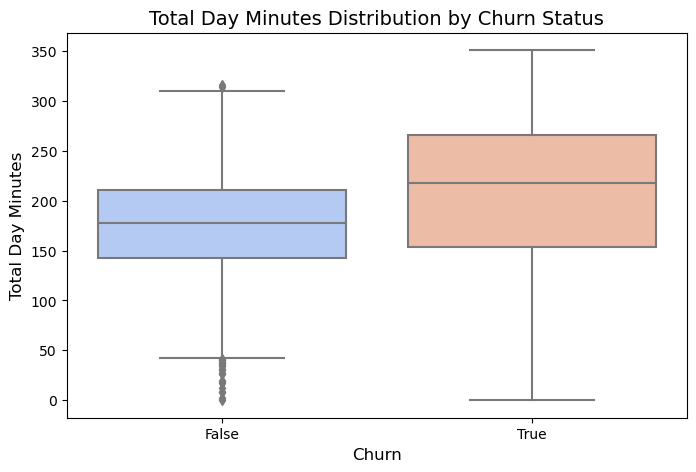

In [11]:
# Scatter plot of total minutes vs. churn to observe any pattern
plt.figure(figsize=(8, 5))
sns.boxplot(x=telecoms_df["churn"], y=telecoms_df["total day minutes"], palette="coolwarm")

# Add labels
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Total Day Minutes", fontsize=12)
plt.title("Total Day Minutes Distribution by Churn Status", fontsize=14)

plt.show()


### Which Features Drive Customer Churn?

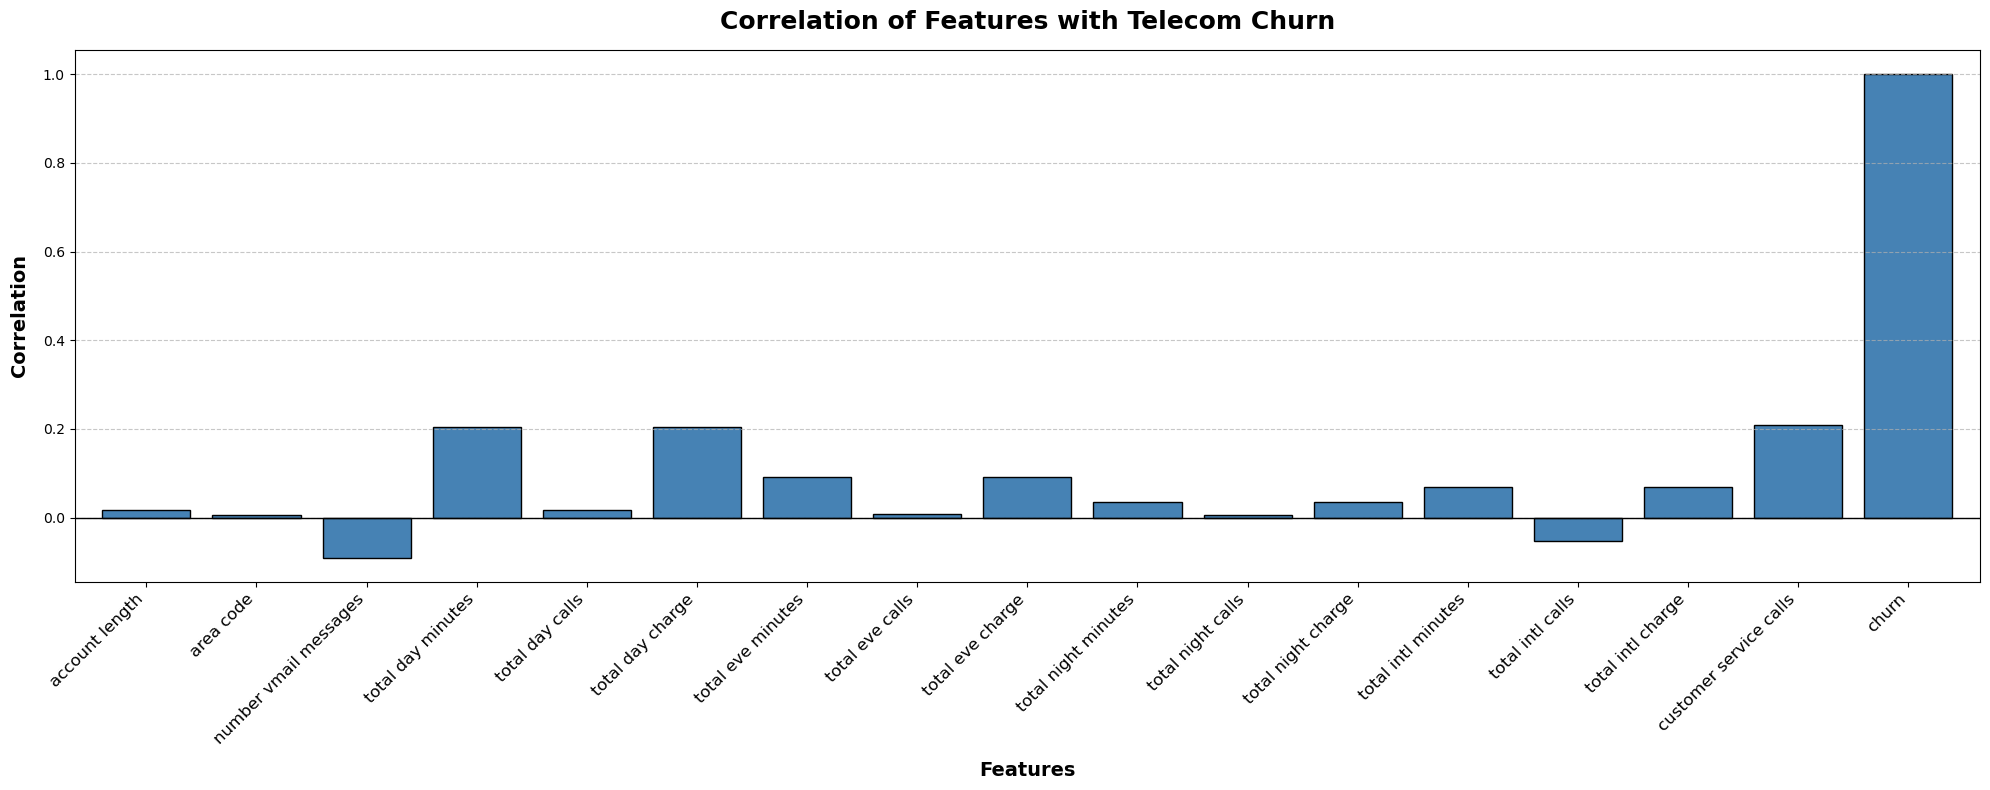

In [12]:
# Compute correlation of features with churn
correlation = telecoms_df.corrwith(telecoms_df['churn'])

# Create figure and axis
fig, ax = plt.subplots(figsize=(20, 8))  # Set figure size for readability
correlation.plot.bar(ax=ax, color='steelblue', width=0.8, edgecolor='black')  # Bar chart with enhancements

# Title and labels formatting
ax.set_title('Correlation of Features with Telecom Churn', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Features', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Correlation', fontsize=14, fontweight='bold', labelpad=10)

# Grid & axis formatting
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Dashed grid for better readability
ax.axhline(0, color='black', linewidth=1)  # Add a reference line at zero

# Rotate x-axis labels for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Optimize layout for better spacing
plt.tight_layout()
plt.show()


- **Total Day Charge & Total Day Minutes** have the highest positive correlation with churn.  
- **Customer Service Calls** is also highly correlated, indicating that frequent complaints may lead to churn.  
- **International Calls & Charges** have some influence.  
- **Number of Voicemail Messages** appears to have a slight negative correlation, meaning customers with voicemail might be less likely to churn.  


**Distribution of features**

In [13]:
# Select numerical features
numerical_features = telecoms_df.select_dtypes(include=['int64', 'float64']).columns

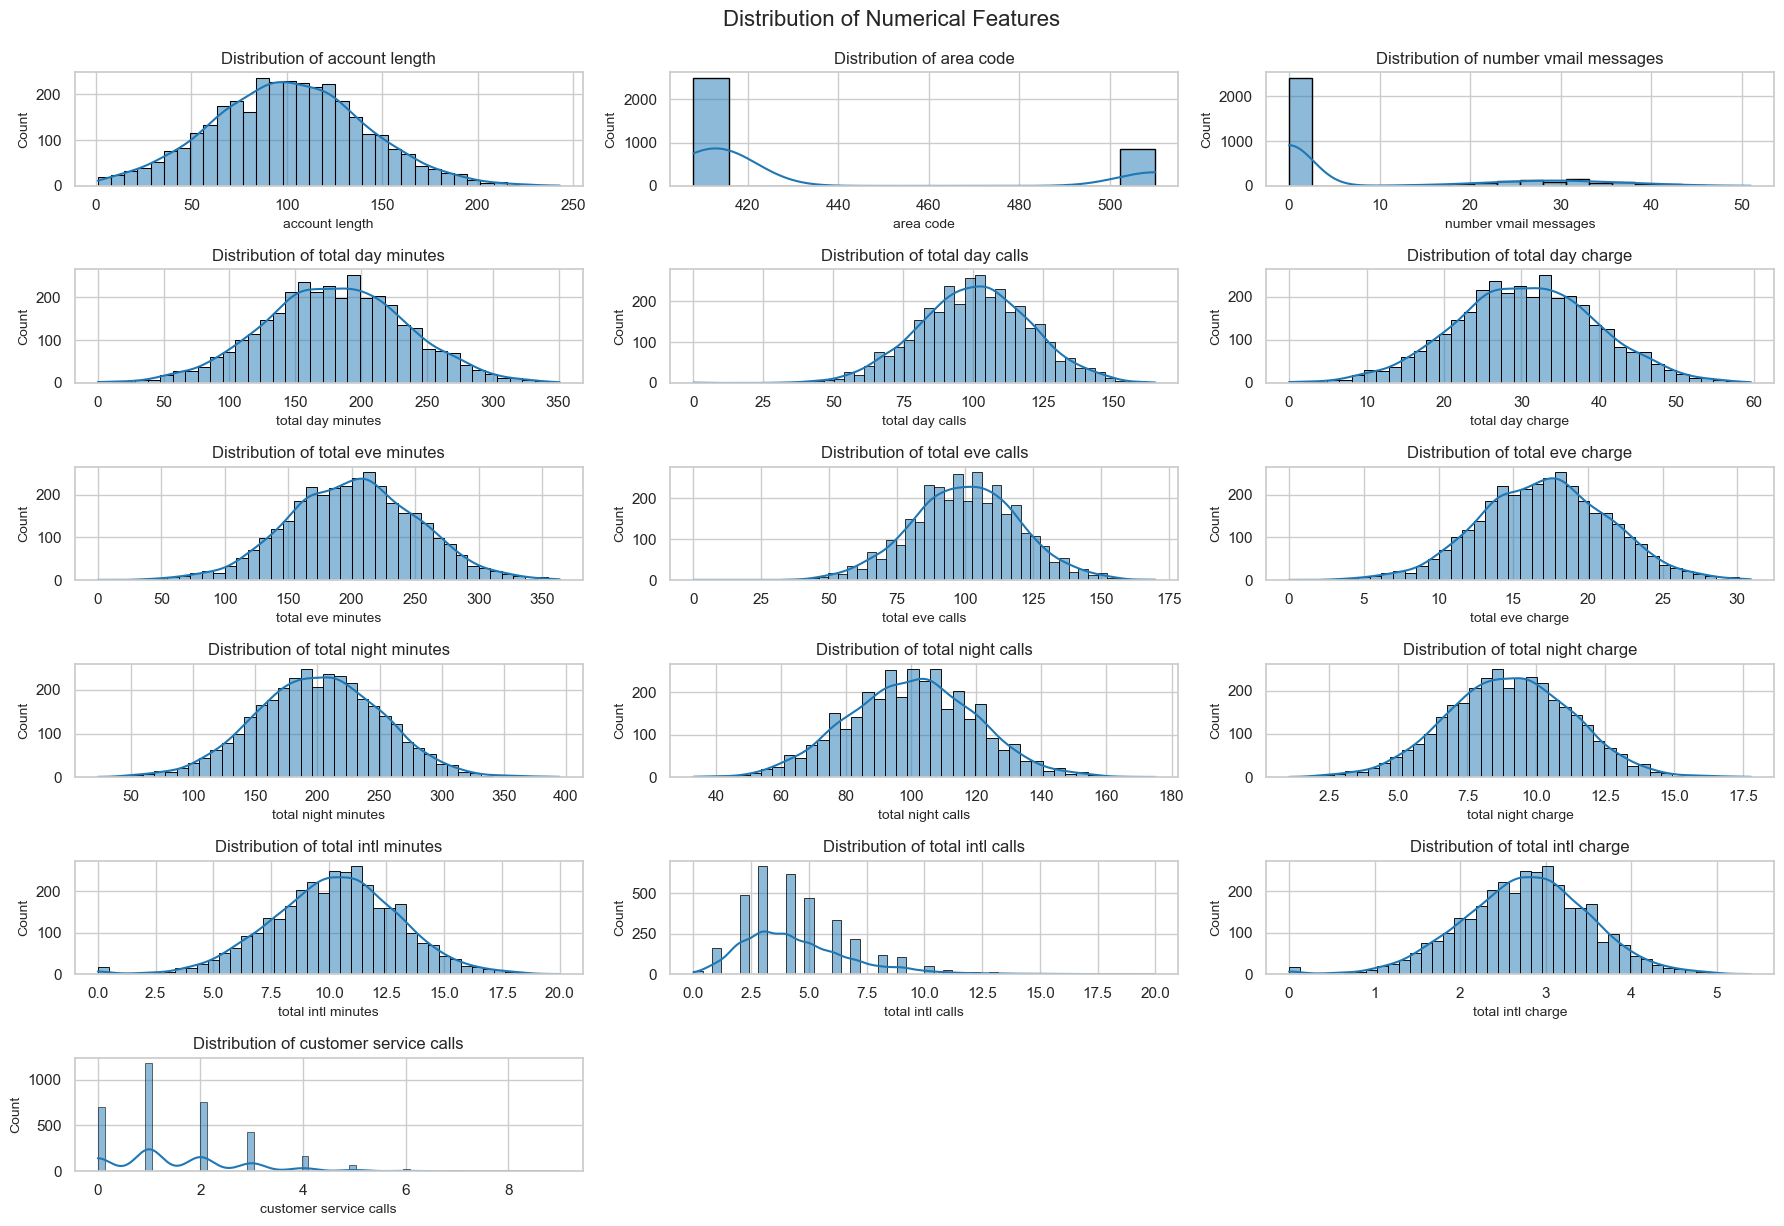

In [14]:
# Set style
sns.set(style='whitegrid')

# Create subplots for better layout
fig, axes = plt.subplots(nrows=len(numerical_features) // 3 + 1, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Plot histograms with blue color
for i, col in enumerate(numerical_features):
    sns.histplot(telecoms_df[col], bins='auto', kde=True, color='#1f77b4', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle('Distribution of Numerical Features', fontsize=16, y=1.02)
plt.show()


- Most features follow a **normal distribution** (i.e`total day minutes`, `total eve minutes`, `total night minutes`).

- `Number of voicemail messages` and `customer service calls` have **skewed distributions**, indicating that most customers make few voicemail messages or service calls.  

- `Total international calls` has a **multi-modal** distribution, suggesting different user groups.  


In [15]:
# Select categorical features
categorical_features = telecoms_df.select_dtypes(include=['object', 'category', 'bool']).columns

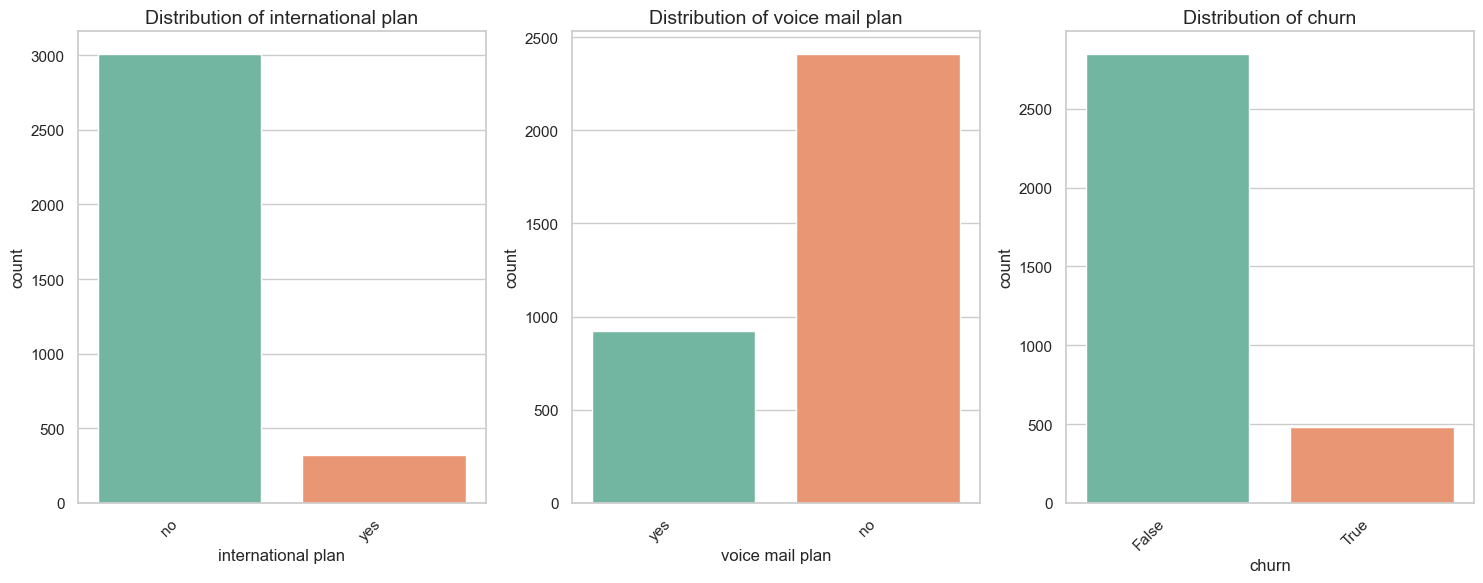

In [16]:
# Exclude 'state' and 'phone number'
categorical_features = [col for col in categorical_features if col not in ['state', 'phone number']]

# Plot bar charts
plt.figure(figsize=(15, 6))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(1, len(categorical_features), i)
    sns.countplot(data=telecoms_df, x=col, palette='Set2')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()

- **International Plan:** Most customers do not have an international plan.
- **Voicemail Plan:** More customers do not use voicemail services.
- **Churn Distribution:** The dataset is highly imbalanced, with fewer customers churning.


# Data Preparation



### 1. **Feature Selection & Cleaning:**
- Dropped `state`, `phone number`, `account length`, and `area code` as non-informative.
- Checked for missing values (none found).


In [17]:
# Drop features that are unlikely to contribute meaningfully to churn prediction
telecoms_df.drop(columns=['phone number','area code','state' ,'account length','number vmail messages'], inplace=True)

In [18]:
telecoms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   international plan      3333 non-null   object 
 1   voice mail plan         3333 non-null   object 
 2   total day minutes       3333 non-null   float64
 3   total day calls         3333 non-null   int64  
 4   total day charge        3333 non-null   float64
 5   total eve minutes       3333 non-null   float64
 6   total eve calls         3333 non-null   int64  
 7   total eve charge        3333 non-null   float64
 8   total night minutes     3333 non-null   float64
 9   total night calls       3333 non-null   int64  
 10  total night charge      3333 non-null   float64
 11  total intl minutes      3333 non-null   float64
 12  total intl calls        3333 non-null   int64  
 13  total intl charge       3333 non-null   float64
 14  customer service calls  3333 non-null   

In [19]:
# Define features to drop based on high VIF values
features_to_drop = ['total day charge', 'total eve charge', 
                 'total night charge', 'total intl calls','voice mail plan']  

# Drop selected features
telecoms_df = telecoms_df.drop(columns=features_to_drop)



### 2. **Feature Engineering:**

- Converted `international plan` and `voice mail plan` into binary indicators (0 = No, 1 = Yes).
- Scaled numerical features for model optimization.


In [20]:
# Convert the 'international plan' to numerical (0/1) values
telecoms_df['international plan'] = telecoms_df['international plan'].map({'no': 0, 'yes': 1})

In [21]:
# Convert 'churn' (boolean) to integer (1/0)
telecoms_df["churn"] = telecoms_df["churn"].astype(int)

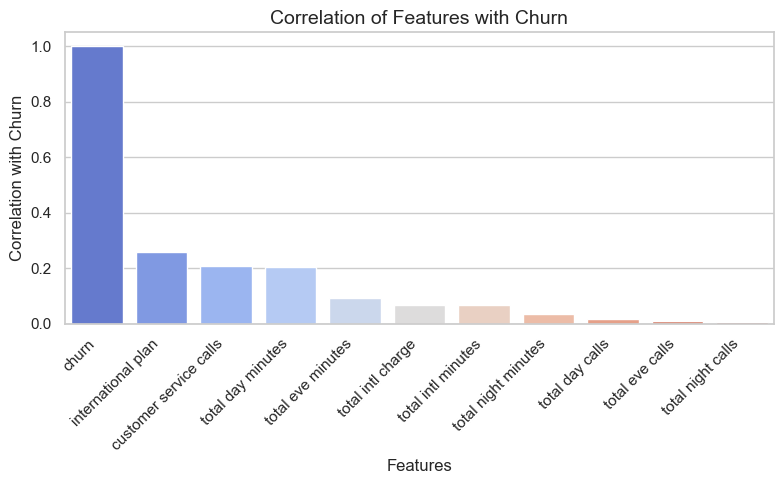

In [22]:
# Compute the correlation with churn and sort the values
correlation = telecoms_df.corr()["churn"].sort_values(ascending=False)

# Plotting the correlation with churn
plt.figure(figsize=(8, 5))
sns.barplot(x=correlation.index, y=correlation.values, palette='coolwarm')

# Adding labels and title
plt.title('Correlation of Features with Churn', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation with Churn', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

In [23]:
# Save the cleaned dataset as a CSV file
telecoms_df.to_csv("Syria Telecoms Churn.csv", index=False)

print("Cleaned dataset saved as 'Syria Telecoms Churn.csv'.")

Cleaned dataset saved as 'Syria Telecoms Churn.csv'.


In [24]:
# Define features (X) and target variable (y)
X = telecoms_df.drop(columns=["churn"])  # Assuming 'churn' is the target variable

y = telecoms_df["churn"].astype(int)  # Convert churn to integer if necessary  

In [25]:
# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Print the shapes of training and testing sets before applying SMOTE (Synthetic Minority Over-sampling Technique)
print("Before Class balancing:")
print(f"X_train shape: {X_train.shape} for the training set")
print(f"y_train shape: {y_train.shape} for the training set")
print(f"X_test shape: {X_test.shape} for the testing set")
print(f"y_test shape: {y_test.shape} for the testing set")

Before Class balancing:
X_train shape: (2666, 10) for the training set
y_train shape: (2666,) for the training set
X_test shape: (667, 10) for the testing set
y_test shape: (667,) for the testing set


### 3. **Handling Imbalance:**
- Evaluating **SMOTE** and **class weighting** to address minority class representation.

In [27]:
# Apply SMOTE to handle class imbalance in the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print new class distribution
print(y_train_smote.value_counts(normalize=True) * 100)

0    50.0
1    50.0
Name: churn, dtype: float64


In [28]:
# Print new shapes of the training set after SMOTE
print("After Class balancing with SMOTE:")
print(f"X_train_smote shape: {X_train_smote.shape} for training")
print(f"y_train_smote shape: {y_train_smote.shape} for training")

After Class balancing with SMOTE:
X_train_smote shape: (4560, 10) for training
y_train_smote shape: (4560,) for training


In [33]:
# Apply StandardScaler to scale the features
scaler = StandardScaler()

# Fit and transform the training set after SMOTE
X_train_scaled = scaler.fit_transform(X_train_smote)

# Transform the test set using the same scaler 
X_test_scaled = scaler.transform(X_test)

In [39]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve


Accuracy: 0.6942
ROC-AUC Score: 0.7904
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79       570
           1       0.29      0.78      0.43        97

    accuracy                           0.69       667
   macro avg       0.62      0.73      0.61       667
weighted avg       0.85      0.69      0.74       667



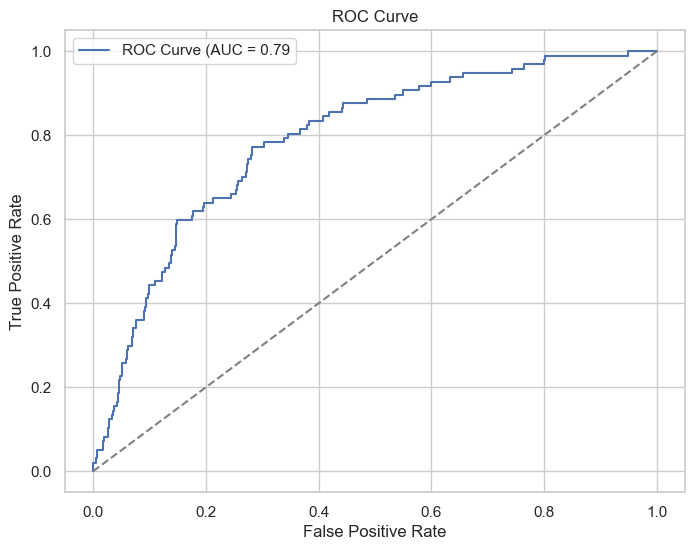

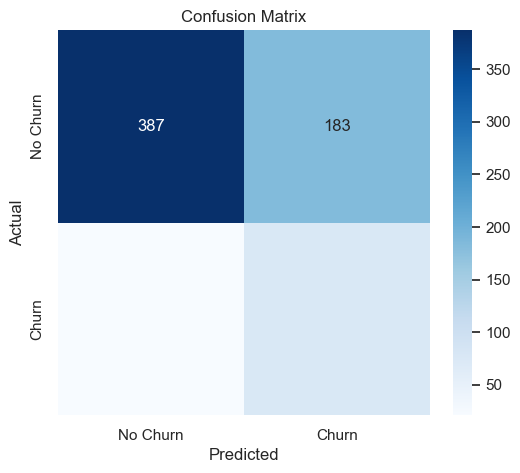

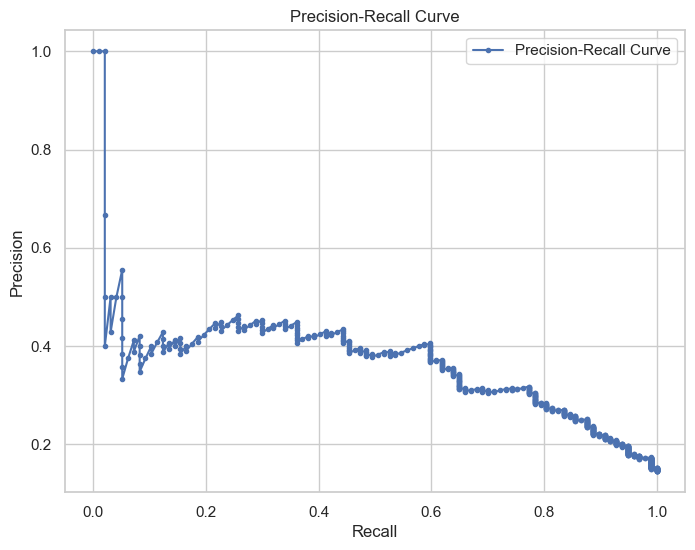

In [41]:
# Train Logistic Regression model with balanced class weights
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', C=0.5)
logreg.fit(X_train_scaled, y_train_smote)

# Make predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", report)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


Accuracy: 0.8516
ROC-AUC Score: 0.8039
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       570
           1       0.49      0.74      0.59        97

    accuracy                           0.85       667
   macro avg       0.72      0.81      0.75       667
weighted avg       0.89      0.85      0.86       667



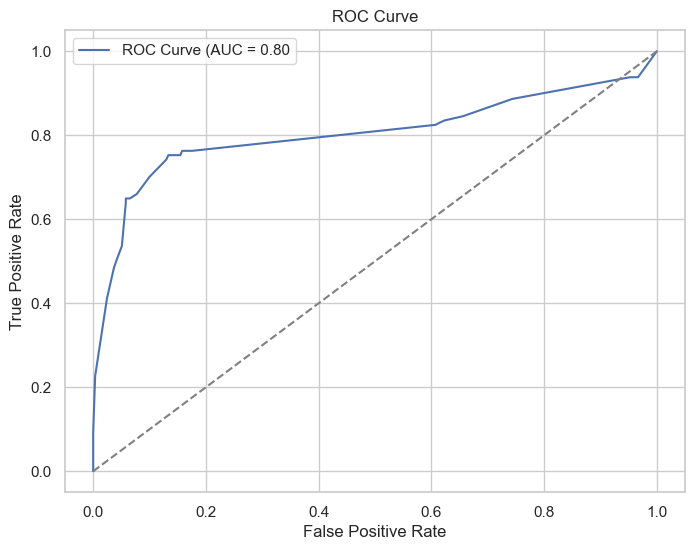

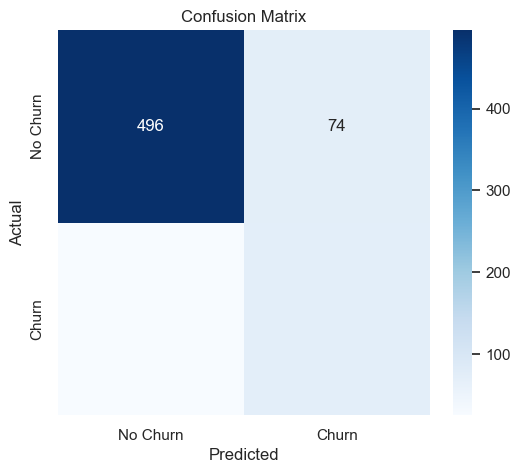

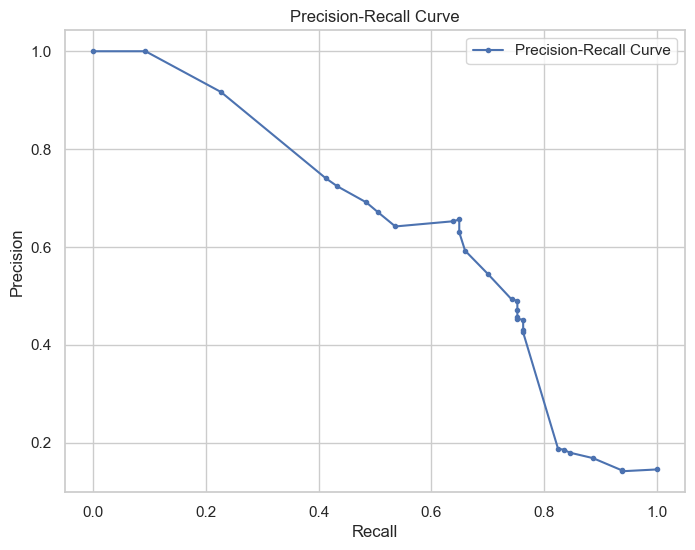

In [42]:
# Train Decision Tree model
dtree = DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42)
dtree.fit(X_train_scaled, y_train_smote)

# Make predictions
y_pred = dtree.predict(X_test_scaled)
y_pred_proba = dtree.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", report)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


Accuracy: 0.8606
ROC-AUC Score: 0.8332
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.91       570
           1       0.51      0.77      0.62        97

    accuracy                           0.86       667
   macro avg       0.74      0.82      0.77       667
weighted avg       0.89      0.86      0.87       667



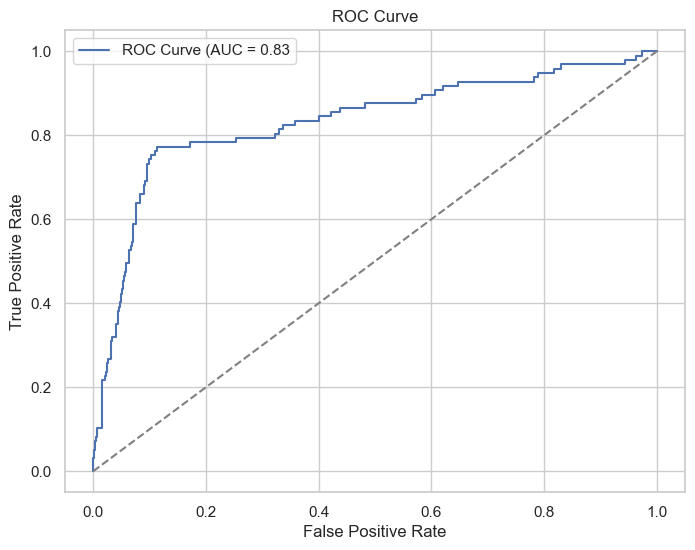

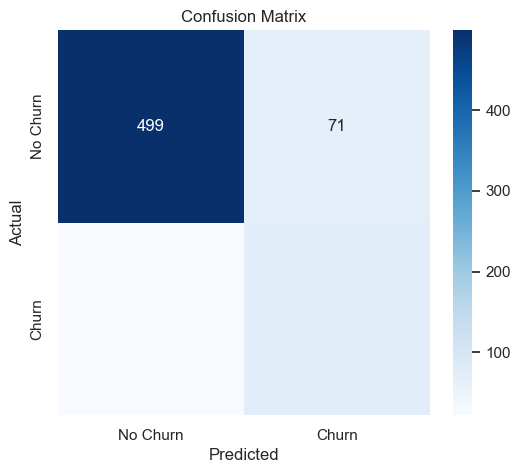

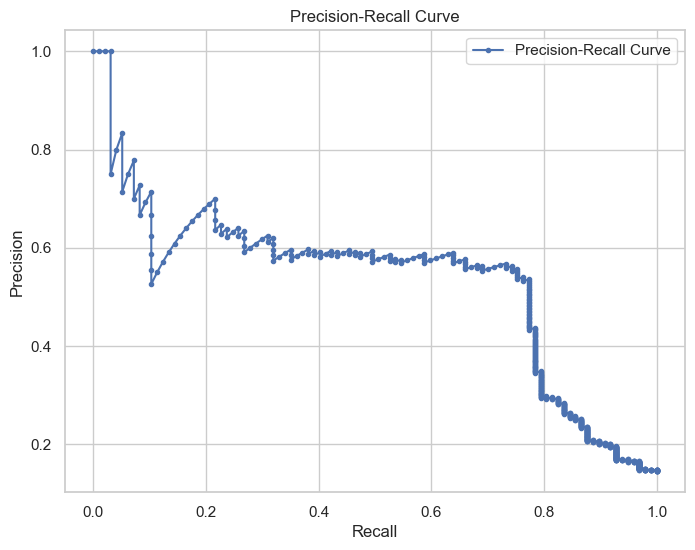

In [43]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=6, random_state=42)
rf.fit(X_train_scaled, y_train_smote)

# Make predictions
y_pred = rf.predict(X_test_scaled)
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", report)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


Accuracy: 0.8351
ROC-AUC Score: 0.8460
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90       570
           1       0.46      0.74      0.57        97

    accuracy                           0.84       667
   macro avg       0.70      0.80      0.73       667
weighted avg       0.88      0.84      0.85       667



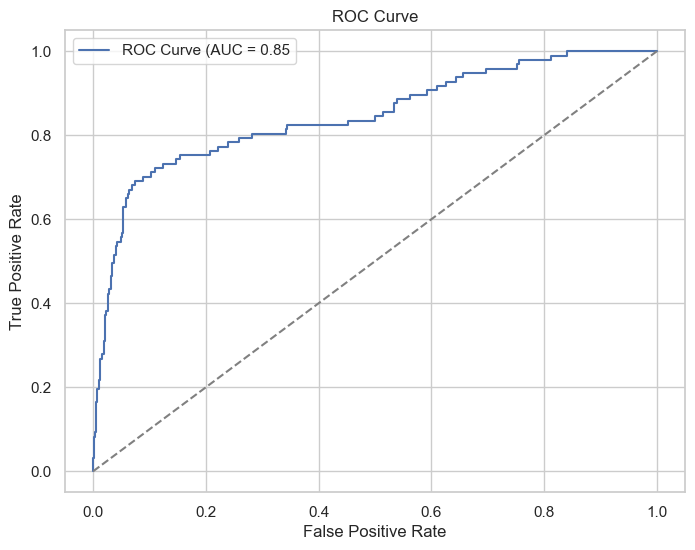

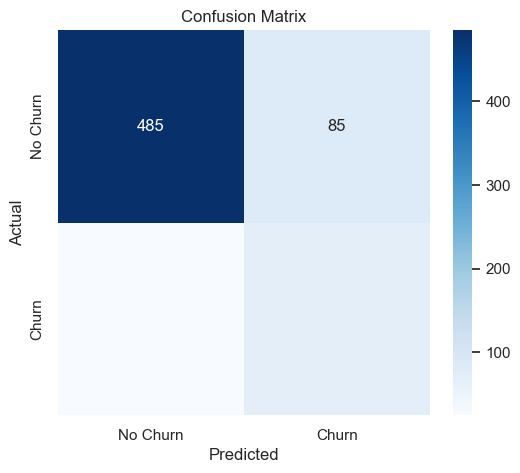

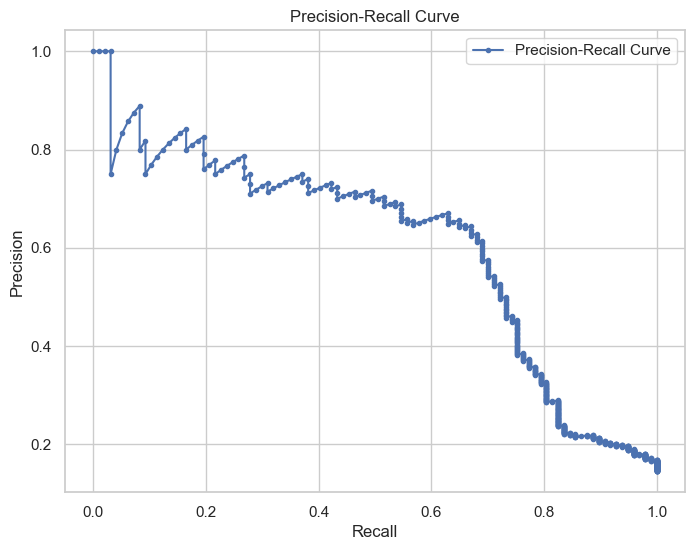

In [44]:
# Train XGBoost model
xgb = XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train_smote)

# Make predictions
y_pred = xgb.predict(X_test_scaled)
y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", report)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

Best XGBoost Params: {'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 5}
Accuracy: 0.8546
ROC-AUC Score: 0.8541
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91       570
           1       0.50      0.76      0.60        97

    accuracy                           0.85       667
   macro avg       0.73      0.82      0.76       667
weighted avg       0.89      0.85      0.87       667



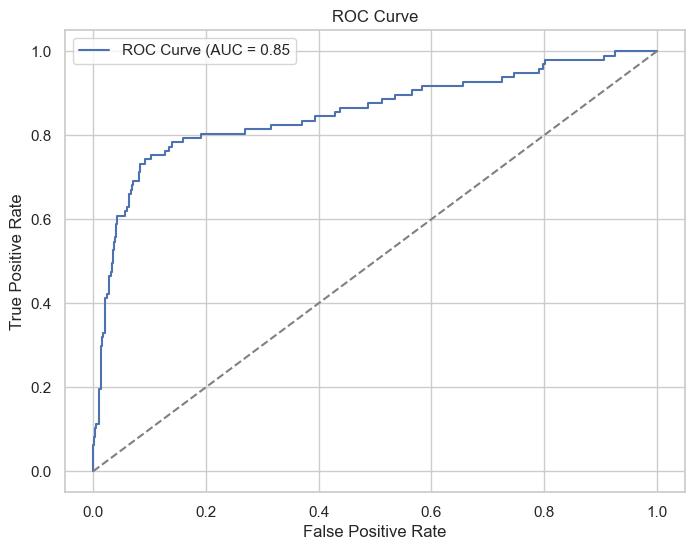

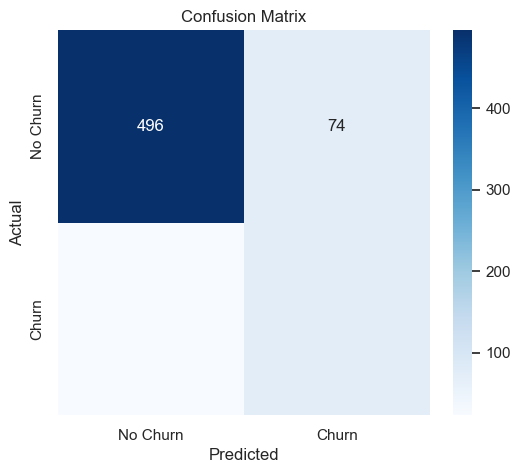

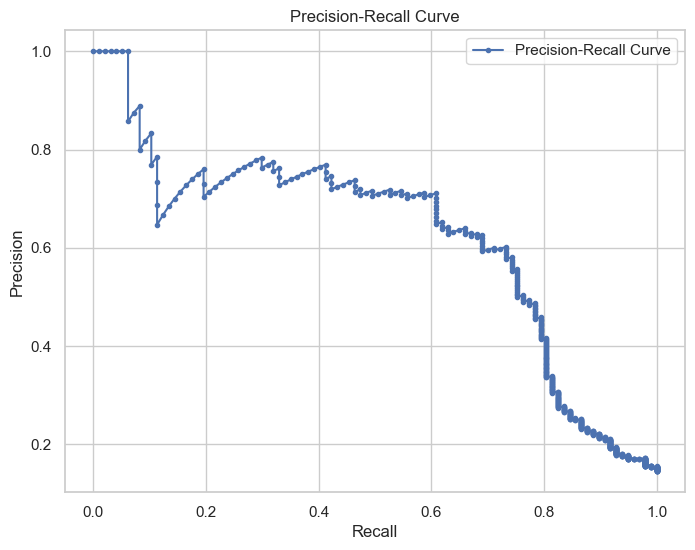

In [45]:
# Hyperparameter tuning for Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [6, 10], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train_smote)
best_rf = rf_grid.best_estimator_

# Hyperparameter tuning for XGBoost
xgb_params = {'n_estimators': [100, 200], 'max_depth': [6, 10], 'scale_pos_weight': [3, 5]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=3, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train_smote)
best_xgb = xgb_grid.best_estimator_

# Evaluate the best model (XGBoost as example)
y_pred = best_xgb.predict(X_test_scaled)
y_pred_proba = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Best XGBoost Params: {xgb_grid.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", report)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
